In [1]:
!pip install torch torchvision torchaudio
import torch as th
import torchvision
import torchvision.transforms as tv_trans
import torch.nn as nn_mod
import torch.optim as optim_mod
from torchvision import models as tv_models
from torch.utils.data import DataLoader as DLLoader, Dataset as ImgDataset
import os
from PIL import Image as Img
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tabulate import tabulate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Loading the dataset

In [49]:
class CustomImgDataset(ImgDataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: (1-i) for i, cls in enumerate(self.classes)} # 0 for Duck, 1 for chicken
        self.images = [(os.path.join(root_dir, img_name),
                         0 if 'duck' in img_name.lower() else 1)  # 0 for Duck, 1 for Chicken
                        for img_name in os.listdir(root_dir)
                        if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))] # Filter for image files

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Img.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

### Making the custom transform for image pre-processing

In [50]:
transform = tv_trans.Compose([
    tv_trans.Resize((224, 224)),
    tv_trans.ToTensor(),
    tv_trans.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The datasets have been saved on google drive for this task, and is mounted on google colab.

In [51]:
train_dataset = CustomImgDataset(root_dir='/content/drive/MyDrive/clean_chicken_duck_split/train', transform=transform)
train_loader = DLLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = CustomImgDataset(root_dir='/content/drive/MyDrive/clean_chicken_duck_split/test', transform=transform)
val_loader = DLLoader(val_dataset, batch_size=12, shuffle=False)

### Loading the pre-trained ResNet18 model

In [52]:
model = tv_models.resnet18(pretrained=True)

In [53]:
num_features = model.fc.in_features
model.fc = nn_mod.Linear(num_features, 2)  # 2 output classes (Duck and Chicken)

In [54]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


For testing purposes we evaluate this model on the validation
dataset, without training

In [55]:
# Evaluation (before training)
model.eval()
correct = 0
total = 0
with th.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = th.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.5556


We get a testing accuracy of 55%

In [56]:

# 1) Collect preds & trues
preds, trues = [], []

with th.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = th.max(outputs, 1)
        preds.extend(predicted.cpu().tolist())
        trues.extend(labels.cpu().tolist())

# 2) Build report dict and DataFrame
report_dict = classification_report(trues,
                                    preds,
                                    output_dict=True,
                                    zero_division=0)
df = pd.DataFrame(report_dict).transpose()

# 3) Convert precision/recall/f1 to % and round
for col in ("precision", "recall", "f1-score"):
    df[col] = (df[col] * 100).round(2)

# 4) Reorder & print as ASCII table
print(
    tabulate(
        df[["precision", "recall", "f1-score", "support"]],
        headers="keys",
        tablefmt="psql",
        floatfmt=".2f",
    )
)


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.00 |     0.00 |       0.00 |     28.00 |
| 1            |       55.56 |   100.00 |      71.43 |     35.00 |
| accuracy     |       55.56 |    55.56 |      55.56 |      0.56 |
| macro avg    |       27.78 |    50.00 |      35.71 |     63.00 |
| weighted avg |       30.86 |    55.56 |      39.68 |     63.00 |
+--------------+-------------+----------+------------+-----------+


### Training the model

+=======+============+
| Epoch | Loss (%)   |
+=======+============+


Epoch 1/6:   0%|          | 0/13 [00:00<?, ?batch/s]

|   1   |    46.71%  |


Epoch 2/6:   0%|          | 0/13 [00:00<?, ?batch/s]

|   2   |    12.18%  |


Epoch 3/6:   0%|          | 0/13 [00:00<?, ?batch/s]

|   3   |     5.92%  |


Epoch 4/6:   0%|          | 0/13 [00:00<?, ?batch/s]

|   4   |     4.35%  |


Epoch 5/6:   0%|          | 0/13 [00:00<?, ?batch/s]

|   5   |     2.87%  |


Epoch 6/6:   0%|          | 0/13 [00:00<?, ?batch/s]

|   6   |     1.94%  |
+-------+------------+


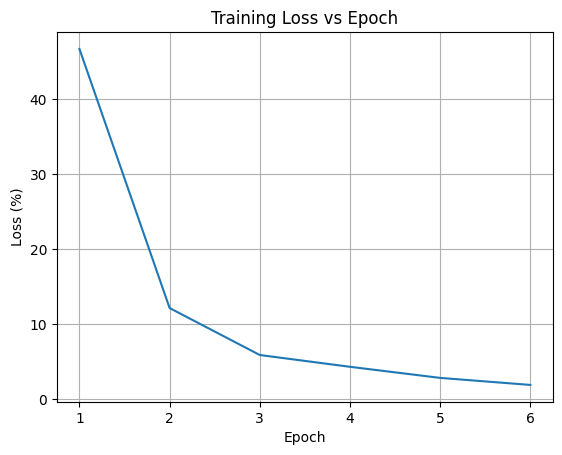

In [22]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Define loss, optimizer and number of epochs
criterion     = nn_mod.CrossEntropyLoss()
optim_modizer = optim_mod.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs    = 6

# List to store loss (%) per epoch
loss_history = []

# Print table header once up front
print("+=======+============+")
print("| Epoch | Loss (%)   |")
print("+=======+============+")

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    # Live batch‑level progress, stays on‑screen
    for inputs, labels in tqdm(
        train_loader,
        desc=f"Epoch {epoch}/{num_epochs}",
        unit="batch",
        leave=True,
    ):
        inputs, labels = inputs.to(device), labels.to(device)
        optim_modizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optim_modizer.step()
        running_loss += loss.item() * inputs.size(0)

    # Compute epoch average loss and convert to percent
    epoch_loss = running_loss / len(train_dataset)
    loss_pct   = epoch_loss * 100
    loss_history.append(loss_pct)

    # Print this epoch’s row in the table
    print(f"|  {epoch:^3}  |   {loss_pct:>6.2f}%  |")

# Print table footer
print("+-------+------------+")

# Plot Training Loss vs. Epoch
epochs = list(range(1, num_epochs + 1))
plt.figure()
plt.plot(epochs, loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (%)')
plt.title('Training Loss vs Epoch')
plt.grid(True)
plt.show()


In [23]:
# Evaluation
model.eval()
correct = 0
total = 0
with th.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = th.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 1.0000


After training, we got an accuracy of around 100%.

### Classification Report

In [24]:

# 1) Collect preds & trues
preds, trues = [], []

with th.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = th.max(outputs, 1)
        preds.extend(predicted.cpu().tolist())
        trues.extend(labels.cpu().tolist())

# 2) Build report dict and DataFrame
report_dict = classification_report(trues,
                                    preds,
                                    output_dict=True,
                                    zero_division=0)
df = pd.DataFrame(report_dict).transpose()

# 3) Convert precision/recall/f1 to % and round
for col in ("precision", "recall", "f1-score"):
    df[col] = (df[col] * 100).round(2)

# 4) Reorder & print as ASCII table
print(
    tabulate(
        df[["precision", "recall", "f1-score", "support"]],
        headers="keys",
        tablefmt="psql",
        floatfmt=".2f",
    )
)


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |      100.00 |   100.00 |     100.00 |     28.00 |
| 1            |      100.00 |   100.00 |     100.00 |     35.00 |
| accuracy     |      100.00 |   100.00 |     100.00 |      1.00 |
| macro avg    |      100.00 |   100.00 |     100.00 |     63.00 |
| weighted avg |      100.00 |   100.00 |     100.00 |     63.00 |
+--------------+-------------+----------+------------+-----------+
